In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.sparse as sp

## Parameters

In [2]:
horizon = 480 #5 days, 15-min intervals


In [3]:
# Create a model:
m = gp.Model("ADR") 

Restricted license - for non-production use only - expires 2026-11-23


## Data Loading

### Electricity demand

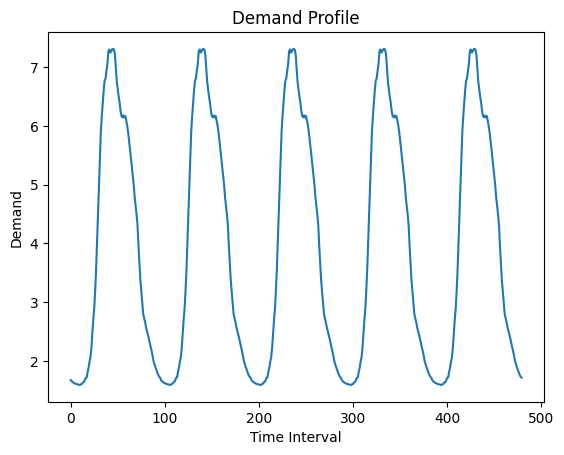

(480, 1)


In [27]:
profile_demand = pd.read_csv('Demand_Data_15min.csv', sep=',', decimal='.')
profile_demand.head()

facteur = 120000/1000000

real_Demand= profile_demand['Demand']*facteur

#plot the Demand Column
plt.plot(real_Demand)
plt.title('Demand Profile')
plt.xlabel('Time Interval')
plt.ylabel('Demand')
plt.show()

#only keep the demand column
profile_demand = profile_demand[['Demand']]
print(profile_demand.shape)

### Solar irradiance

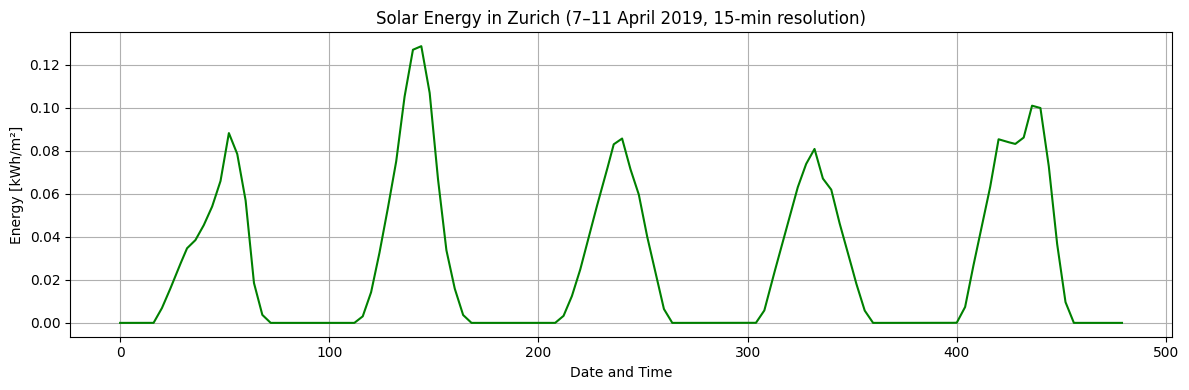

(480, 2)


In [7]:
solar_energy = pd.read_csv('Solar_Energy_Zurich_15min.csv')
# Plot the solar energy (kWh/m²) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(solar_energy.index, solar_energy['Energy [kWh/m²]'], color='green')
plt.title('Solar Energy in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Energy [kWh/m²]')
plt.grid(True)
plt.tight_layout()
plt.show()

print(solar_energy.shape)

In [ ]:
solar_energy.head()
PV_area = 200 # m²
PV_efficiency = 0.2 # 20% efficiency
PV_elec = solar_energy['Energy [kWh/m²]'] * PV_area * PV_efficiency # kWh

# Plot the solar energy (kWh) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(solar_energy.index, PV_elec, color='green')
plt.title('PV Energy generated in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Energy [kWh]')
plt.grid(True)
plt.tight_layout()
plt.show()  


In [ ]:
print(PV_elec.shape)
print(PV_elec[:120])

## Modelling 

### EVs:

In [ ]:
# --- PARAMETERS ---
n_evs        = 15          # number of EVs
P_rated      = 4.0         # kW, max charger power
E_req        = 6.0         # kWh, daily depleted energy of 6 kWh per EV
dt           = 15/60       # hours per time step (15 min ⇒ 0.25 h)
T_day        = 96          # total 15-min slots per day
days         = 5           # number of days
start_idx    = 9 * 4       # 9:00 → slot 36
end_idx      = 18 * 4      # 18:00 → slot 72 (exclusive upper bound)
# index sets
evs = range(n_evs) 
slots = range(T)
days_ = range(days)

# continuous variable p[e,t] ∈ [0, P_rated] = charging power of EV e in slot t (kW)
p = m.addVars(evs, days, slots, #create set of decision variables, indexed by EVs, time slots and day
            #each variable p[e, t] corresponds to the charging power of EV e during time slot t in kW
            vtype=GRB.CONTINUOUS,
            lb=0.0, # lower bound of the variable
            ub=P_rated, # upper bound of the variable, P_rated is the maximum charging power
            name="p") #base name of the variable

# 1) Energy requirement: each EV must accumulate E_req kWh over the allowed window
for e in evs:
    for d in days_:
        m.addConstr(
            gb.quicksum(p[e,d,t] * dt for t in range(start_idx, end_idx)) == E_req,
            name=f"energy_e{e}_d{d}"
        )

# 2) Enforce zero charging outside [9:00,18:00), each day.
for e in evs:
    for d in days_:
        # before 9:00
        for t in range(0, start_idx):
            m.addConstr(p[e,d,t] == 0,
                        name=f"zero_before_e{e}_d{d}_t{t}")
        # after 18:00
        for t in range(end_idx, T_day):
            m.addConstr(p[e,d,t] == 0,
                        name=f"zero_after_e{e}_d{d}_t{t}")

# (the ub=P_rated on p already enforces p[e,t] ≤ P_rated for all t)

### Additive Manufacturing (AM) Machines

In [ ]:
# Parameters
n_AMM = 5 # number of AM machines
power_AMM = 2.76  # Power consumption of each printer in kW

# Full cycle of a printer corresponds to 4 hours of operation (or 16 slots of 15 minutes)
full_cycle = 16

# Decision variable, x[t] = 1 if appliance starts at time t
x = m.addVars(,name=)

# Printer start only once per cycle


# Last feasible time to start

# Constraint

# Every day, 20 pieces must be produced
model.addConstr(
    gp.quicksum(x[m, t] for m in range(M) for t in range(T - D + 1)) >= 20,
    name="min_production"
)
